In [8]:
## IMPORT CUSTOM CAPSTONE FUNCTIONS
import functions_combined_BEST as ji
import functions_io as io

In [1]:
!pip install -U fsds
from fsds.imports import *

fsds v0.2.27 loaded.  Read the docs: https://fs-ds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


[i] Pandas .iplot() method activated.


In [2]:
import os,sys
sys.path.append('py_files/')

# OBTAIN

### DATA SOURCES:

* **All Donald Trump tweets from 12/01/2016 (pre-inaugaration day) to end of 08/23/2018**
    *          Extracted from http://www.trumptwitterarchive.com/

* **Minute-resolution data for the S&P500 covering the same time period.**
    *         IVE S&P500 Index from - http://www.kibot.com/free_historical_data.aspx
    - (***Aggregate 1 min bid-ask data link***)
        - http://api.kibot.com/?action=history&symbol=IVE&interval=tickbidask1&bp=1&user=guest
    
    
* NOTE: Both sources required manual extraction and both 1-min historical stock data and batch-historical-tweet data are difficult to obtain without paying \\$150-\\$2000 monthly developer memberships. 

In [3]:
# ## Attempt to Get Stock Data With Code

import requests
import pandas as pd

def download_stock_data(fpath='data/ive_minute_tick_bidask_API.csv',
                       verbose=True):
    """Downloads up-to-date IVE S&P 500 1-min aggregate data from 
    http://www.kibot.com/free_historical_data.aspx
    
    Args:
        fpath (str): csv filepath to save (Default='data/ive_minute_tick_bidask_API.csv')
        verbose (bool): Display file info (Default=True)
        
    Returns:
        stock_df: DataFrame with correct headers and datetime index"""
    agg_url = 'http://api.kibot.com/?action=history&symbol=IVE&interval=tickbidask1&bp=1&user=guest'
    response = requests.get(agg_url,
                            allow_redirects=True)

    ## Save output to csv file
    with open(fpath,'wb') as file:
        file.write(response.content)
        
        
    ## Load in Stock Data Frame with headers (then save)
    headers = ['Date','Time','BidOpen','BidHigh','BidLow','BidClose','AskOpen','AskHigh','AskLow','AskClose']
    stock_df = pd.read_csv(fpath,names=headers)

# 
    ## Make Combined Date Time column and Drop Origs
    stock_df['datetime'] = pd.to_datetime(stock_df['Date'].astype(str)+' '+stock_df['Time'].astype(str))
    stock_df.to_csv(fpath,index=False)
        
    if verbose:
        print('[i] Data successfully downloaded and saved as:')
        print(' - ',fpath)
        
    return pd.read_csv(fpath,parse_dates=['datetime'],index_col='datetime')

In [4]:
# stock_df = download_stock_data_csv()
stock_df = pd.read_csv('data/ive_minute_tick_bidask_API.csv',
                       parse_dates=['datetime'],
                       index_col='datetime')

## Remove Other Columns
stock_df = stock_df[['BidOpen','BidClose']]

In [5]:
stock_df.shape

(888301, 2)

In [6]:
## Remove rare 0-values
stock_df = stock_df[(stock_df>0).all(axis=1)]
stock_df.shape

(888284, 2)

<AxesSubplot:xlabel='datetime'>

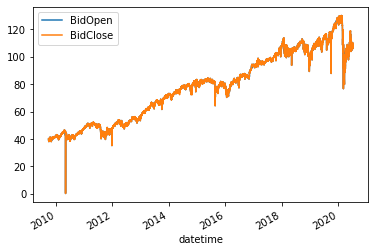

In [7]:
stock_df.plot()

## Tweet Preprocessing

In [12]:
raw_tweets = 'data/trump_twitter_archive_07112020.csv'
df = pd.read_csv(raw_tweets,parse_dates=['created_at'])#,index_col='created_at')
df

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,RT @GreggJarrett: Pelosi Shrugs Off Mobs ‘Peop...,2020-07-11 18:44:28,4728,0,True,1282022963987054592
1,Twitter for iPhone,RT @GreggJarrett: Trump right to commute Roger...,2020-07-11 18:43:57,8574,0,True,1282022835867791361
2,Twitter for iPhone,RT @GreggJarrett: Biased anti-Flynn rogue judg...,2020-07-11 18:43:47,6188,0,True,1282022791857025025
3,Twitter for iPhone,RT @TVNewsHQ: Fox News’ @GreggJarrett on Presi...,2020-07-11 18:42:55,3612,0,True,1282022576441700356
4,Twitter for iPhone,RT @realDonaldTrump: President Trump Approval ...,2020-07-11 13:16:00,39286,0,True,1281940302782136320
...,...,...,...,...,...,...,...
24015,Twitter for Android,Well the year has officially begun. I have man...,2016-01-01 23:00:09,2642,8495,False,683060169677344768
24016,Twitter for Android,@sprinklermanus: @CNN @realDonaldTrump they're...,2016-01-01 21:29:56,933,3330,False,683037464504745985
24017,Twitter for Android,@jallenaip: Hillary said she was in a Fog of W...,2016-01-01 06:08:06,2721,7490,False,682805477168779264
24018,Twitter for iPhone,Happy New Year from #MarALago! Thank you to my...,2016-01-01 06:07:28,1948,8258,False,682805320217980929


In [11]:
df.index

DatetimeIndex(['2020-07-11 18:44:28', '2020-07-11 18:43:57',
               '2020-07-11 18:43:47', '2020-07-11 18:42:55',
               '2020-07-11 13:16:00', '2020-07-11 13:15:18',
               '2020-07-11 13:15:08', '2020-07-11 13:14:41',
               '2020-07-11 13:14:38', '2020-07-11 13:12:56',
               ...
               '2016-01-01 23:24:13', '2016-01-01 23:10:25',
               '2016-01-01 23:08:18', '2016-01-01 23:06:09',
               '2016-01-01 23:02:05', '2016-01-01 23:00:09',
               '2016-01-01 21:29:56', '2016-01-01 06:08:06',
               '2016-01-01 06:07:28', '2016-01-01 05:18:23'],
              dtype='datetime64[ns]', name='created_at', length=24020, freq=None)